In [1]:
# https://stackoverflow.com/questions/44527452/cant-open-lib-odbc-driver-13-for-sql-server-sym-linking-issue
import pyodbc
from datetime import datetime
import sqlalchemy
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# local config.py file with credentials for snapshot of database
import config

In [2]:
query = """
select se.Id as enrollment_id,
       se.StudentId as enrollment_student_id,
       se.EnrollmentDate as enrollment_date,
       se.RegisteringSiteId as site_id,
       se.FacilityCode as facility_id,
       se.UserName as user_name,
       se.DateCreated as enrollment_date_created,
       se.ModifiedDate as enrollment_date_modified,
       se.CreatedBy as enrollment_created_by,
       se.ModifiedBy as enrollment_modified_by,
       s.Id as student_student_id,
       s.DateCreated as student_date_created,
       s.DateModified as student_date_modified,
       s.IsHispanic as is_hispanic,
       s.CreatedBy as student_created_by,
       s.ModifiedBy as student_modified_by,
       s.DateOfBirth as date_of_birth,
       s.SASID,
       s.SASIDManagerId sasid_manager_id,
       string_agg(sr.RaceCode,',') as races,
       agency.Name as agency_name,
       agency.Type as agency_type,
       agency.ParentOrganization as agency_parent,
       site.Name as site_name,
       site.ParentOrganization as site_parent
from Student.Enrollment as se
    inner join Student.Student as s on se.StudentId = s.Id
left outer join Student.Race as sr on se.StudentId = sr.StudentId
left outer join Universal.Agency as agency on agency.Code = se.FacilityCode
left outer join Universal.Agency as site on site.Code = se.RegisteringSiteId
GROUP BY se.StudentId, se.EnrollmentDate, se.RegisteringSiteId, se.FacilityCode, se.UserName,
         agency.Name, agency.ParentOrganization, site.Name, site.ParentOrganization, se.DateCreated, se.ModifiedDate,
         se.CreatedBy, se.ModifiedBy, s.DateCreated, s.CreatedBy, 
         s.ModifiedBy, s.IsHispanic, s.DateModified, s.DateOfBirth, s.SASID, s.SASIDManagerId, agency.Type, s.Id,
         se.Id
"""
# Pull data from db
engine = sqlalchemy.create_engine(f"mssql+pyodbc://{config.DB_USER}:{config.DB_PASS}@{config.SERVER}/{config.DB_NAME}?driver=ODBC+Driver+17+for+SQL+Server")
df = pd.read_sql(sql=query, con=engine)

In [3]:
SCHOOL_YEAR_START = 7
def get_current_month_object(period_object, default_year=2020):
    """
    Convert a historical time object to the present school year in the same month
    """ 
    try:
        month = period_object.end_time.month
    except:
        month = period_object.month
    year = default_year if month < SCHOOL_YEAR_START else default_year - 1
    
    return datetime(year=year, month=month, day=1)

def get_school_year(period_object):
    """
    Get FY school year from a time object
    """
    
    try:
        month = period_object.end_time.month
    except:
        month = period_object.month
    year = period_object.year
    
    school_year = f"{year}-{year+1}" if month >= SCHOOL_YEAR_START else f"{year-1}-{year}"
    return school_year
    

In [4]:
def create_diff_report(df, diff_col, type_name, time_diff):
    """
    Build a graph showing the distribution 
    """
    diff_df = df[df[diff_col] > pd.Timedelta(time_diff)]
    ax = sns.distplot(diff_df[diff_col].dt.days / 30, kde=False)
    ax.set_title(f'Diff between mod and create - {type_name}')
    ax.set_xlabel('Approx. # of months (30 day periods)')
    plt.show()
    print(f"{len(diff_df)} rows out of {len(df)} ({round(len(diff_df)/len(df)*100,2)}%) for {type_name} were modified more than {time_diff} after creation\n\n\n")

In [5]:
def plot_years(date_col, grouped_col, df, title):
    """
    Plot multiple years of distinct counts for a given column over a school year
    date_col: date column to plot time on
    grouped_col: data to get distinct counts
    df: data
    title: title for chart
    """
    # Group by month, recording adjusted month for graphing on a single axis
    df_month_created = df.copy()
    df_month_created['month_year'] = df[date_col].dt.to_period('M')
    grouped_month_created = df_month_created.groupby(by=['month_year'])[grouped_col].nunique().reset_index()
    grouped_month_created['adjusted_month_num'] = grouped_month_created['month_year'].apply(get_current_month_object)
    grouped_month_created['year'] = grouped_month_created['month_year'].apply(get_school_year)
    num_years = len(grouped_month_created.year.unique())
    ax = sns.lineplot(x='adjusted_month_num', y=grouped_col, data=grouped_month_created, hue='year', palette=sns.color_palette('bright',num_years))
    
    # Sort months and convert into short strings for x-axis labels

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.ylim(0)
    plt.ylabel('')
    plt.xlabel('')
    # Configure plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title(title)
    plt.show()
    return grouped_month_created

In [6]:
def plot_school_year_chart(df, title):
    """
    Plot summarized data over school years for students and enrollments by creation date
    """
    student_df = df.groupby(by='student_create_school_year').nunique()['student_student_id']
    enrollment_df = df.groupby(by='enrollment_create_school_year').nunique()['enrollment_id']
    final_df = pd.concat([student_df,enrollment_df], axis=1)
    final_df.columns = ['Students', 'Enrollments']
    ax = sns.lineplot(data=final_df)
    plt.ylim(0)
    plt.title(title)
    plt.show()
    print(final_df)
    return final_df

In [7]:
# Build columns with difference between modified and created
df['enrollment_create_mod_diff'] = df['enrollment_date_modified'] - df['enrollment_date_created']
df['student_create_mod_diff'] = df['student_date_modified'] - df['student_date_created']

# Add school year columns
df['student_create_school_year'] = df['student_date_created'].apply(get_school_year)
df['student_mod_school_year'] = df['student_date_modified'].apply(get_school_year)
df['enrollment_create_school_year'] = df['enrollment_date_created'].apply(get_school_year)
df['enrollment_mod_school_year'] = df['enrollment_date_modified'].apply(get_school_year)

## Check time and count of edits of students and enrollments

In [8]:
print(f"{sum(df['enrollment_date_modified'].isnull())} enrollments have null modified")
print(f"{sum(df['student_date_modified'].isnull())} students have null modified\n")
print(df['enrollment_create_mod_diff'].describe())
print('\n')
print(df['student_create_mod_diff'].describe())

55480 enrollments have null modified
0 students have null modified

count                       10714
mean      67 days 22:18:20.712944
std      170 days 09:12:09.796267
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%               0 days 00:00:00
max      896 days 00:07:46.507000
Name: enrollment_create_mod_diff, dtype: object


count                       66194
mean      22 days 07:16:08.672794
std      107 days 09:08:09.551691
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%               0 days 00:00:00
max      995 days 08:39:07.727000
Name: student_create_mod_diff, dtype: object


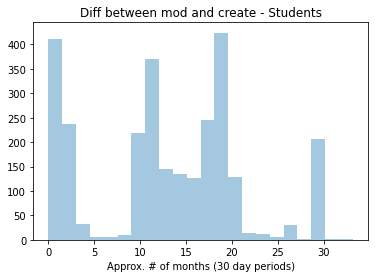

2766 rows out of 54890 (5.04%) for Students were modified more than 1 hour after creation





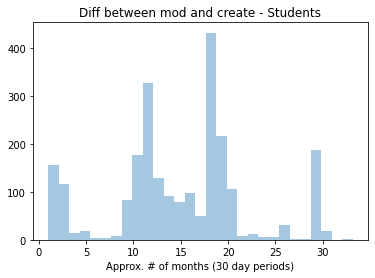

2386 rows out of 54890 (4.35%) for Students were modified more than 30 days after creation





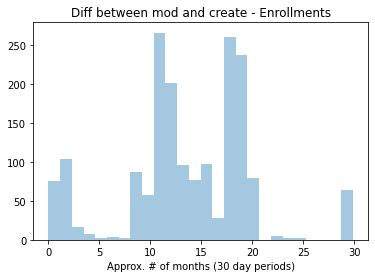

1769 rows out of 66194 (2.67%) for Enrollments were modified more than 1 hour after creation





In [9]:
create_diff_report(df.drop_duplicates('student_student_id'), 'student_create_mod_diff', 'Students', '1 hour')
create_diff_report(df.drop_duplicates('student_student_id'), 'student_create_mod_diff', 'Students', '30 days')
create_diff_report(df, 'enrollment_create_mod_diff', 'Enrollments', '1 hour')

## Plot seasonality of ECIS usage

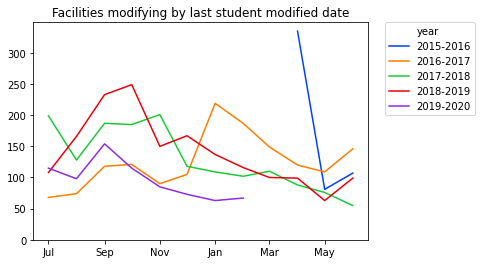

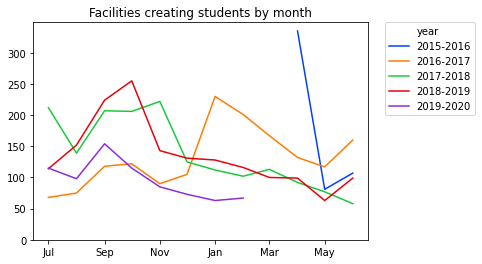

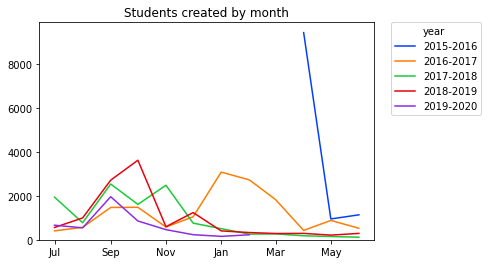

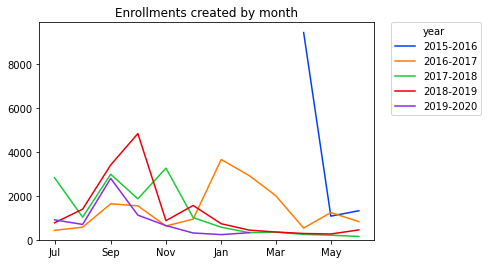

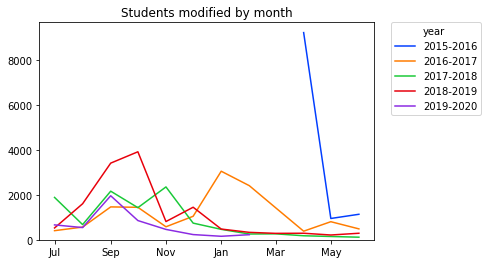

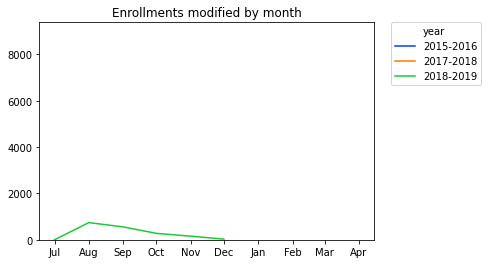

In [10]:
plot_years('student_date_modified', 'facility_id', df, 'Facilities modifying by last student modified date')
plot_years('student_date_created', 'facility_id', df, 'Facilities creating students by month')
plot_years('student_date_created', 'student_student_id', df, 'Students created by month')
plot_years('enrollment_date_created', 'enrollment_id', df, 'Enrollments created by month')
plot_years('student_date_modified', 'student_student_id', df, 'Students modified by month')
grouped_enrollment_mod = plot_years('enrollment_date_modified', 'enrollment_id', df, 'Enrollments modified by month')

#### Remove 2016 spiked data

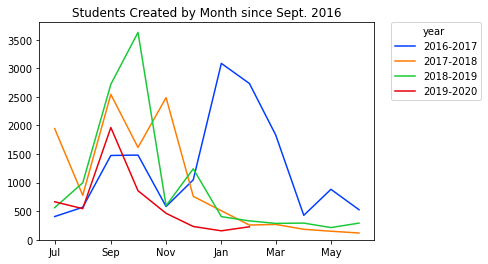

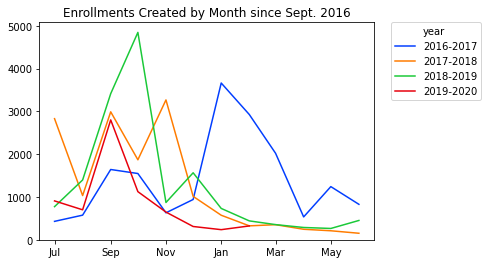

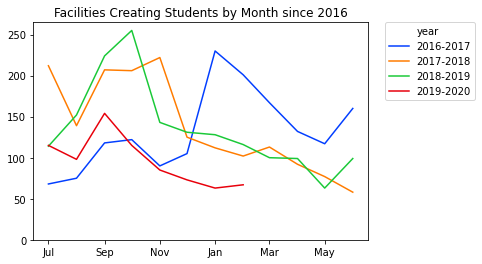

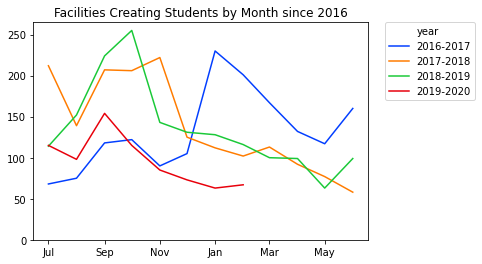

In [11]:
post_2016_student_df = df[df['student_create_school_year'] != '2015-2016']
post_2016_enrollment_df = df[df['enrollment_create_school_year'] != '2015-2016']
plot_years('student_date_created', 'student_student_id', post_2016_student_df, 'Students Created by Month since Sept. 2016')
plot_years('enrollment_date_created', 'enrollment_id', post_2016_enrollment_df, 'Enrollments Created by Month since Sept. 2016')
_ = plot_years('student_date_created', 'facility_id', post_2016_student_df, 'Facilities Creating Students by Month since 2016')
_ = plot_years('student_date_created', 'facility_id', post_2016_student_df, 'Facilities Creating Students by Month since 2016')


/Users/kylemagida/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/generic.py:611: FutureWarning: In the future, NAT != NAT will be True rather than False.
  inc = np.r_[1, val[1:] != val[:-1]]


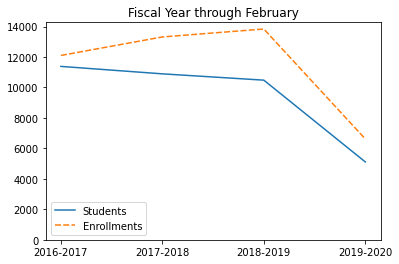

           Students  Enrollments
2016-2017     11384        12103
2017-2018     10895        13318
2018-2019     10481        13839
2019-2020      5113         6622


/Users/kylemagida/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/generic.py:611: FutureWarning: In the future, NAT != NAT will be True rather than False.
  inc = np.r_[1, val[1:] != val[:-1]]


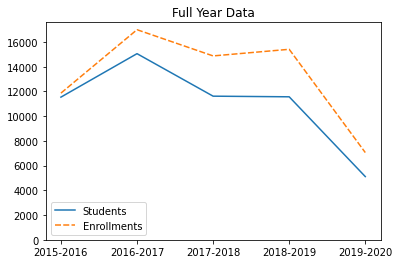

           Students  Enrollments
2015-2016     11539        11863
2016-2017     15055        16993
2017-2018     11617        14873
2018-2019     11566        15408
2019-2020      5113         7057


In [12]:
df['student_date_created_adj_month'] = df['student_date_created'].apply(get_current_month_object)
early_year = df[df['student_date_created_adj_month'] < '2020-03-01']
partial_year_df = plot_school_year_chart(early_year, 'Fiscal Year through February')
full_year_df = plot_school_year_chart(df, "Full Year Data")

In [13]:
partial_year_df.columns = ['partial_students','partial_enrollments']
full_year_df = full_year_df.drop('2015-2016')
full_year_df.columns = ['full_students','full_enrollments']
combined_df = pd.concat([full_year_df, partial_year_df], axis=1)

In [14]:
last_two_years = combined_df.loc[['2017-2018', '2018-2019'],].mean()
cur_year = combined_df.loc[['2019-2020']]
cur_year / last_two_years

,full_students,full_enrollments,partial_students,partial_enrollments
2019-2020,0.441099,0.466101,0.478387,0.487683


In [15]:
# Use average of last two years to estimate rate
student_rate = last_two_years['partial_students'] / last_two_years['full_students']
enrollment_rate = last_two_years['partial_enrollments'] / last_two_years['full_enrollments']
# Get expected totals
print(f"Historical averages: \n\n{last_two_years[['full_students','full_enrollments']]}\n")
print(f"Expected students: {combined_df.loc['2019-2020']['full_students'] / student_rate}")
print(f"Expected enrollments: {combined_df.loc['2019-2020']['full_enrollments'] / enrollment_rate}")

Historical averages: 

full_students       11591.5
full_enrollments    15140.5
dtype: float64

Expected students: 5545.2226328592815
Expected enrollments: 7868.800567072946


### Facility characteristics

/Users/kylemagida/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/generic.py:611: FutureWarning: In the future, NAT != NAT will be True rather than False.
  inc = np.r_[1, val[1:] != val[:-1]]


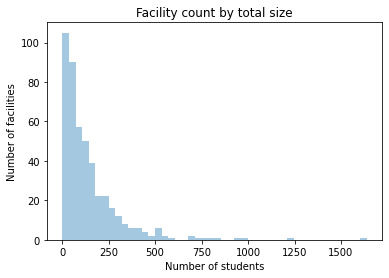

In [16]:
facility_df = df.groupby(by='facility_id').nunique()
sns.distplot(facility_df['enrollment_id'], kde=False)
plt.title("Facility count by total size")
plt.xlabel("Number of students")
plt.ylabel("Number of facilities")
plt.show()